In [1]:
import data_utils as util
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import exp_util

# data preprocessing

In [2]:
#######################################################
# Load the feature header
#######################################################
import csv

# read the csv file
feature_names = []
with open('./data/header.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        feature_names.append(line)

# Dirty tricks to clean up the feature names
feature_names = feature_names[0]
feature_names = list(map(lambda x: x.replace(' ', '_'), feature_names))
feature_names[0] = 'PharmGKB_Subject_ID' # manual fix to remove a character in f...[0]

In [3]:
####################################################################
# Load the dataframe into X; clean up some unnecessary columns 
####################################################################

# Load data and process column names
df = pd.read_csv('./data/warfarin_with_dose.csv', names = feature_names)
#keep_default_na=False)
df.columns = [c.replace(' ', '_') for c in df.columns]

# Extract the label (Warfarin dose) from the rest of the features
y = df.Therapeutic_Dose_of_Warfarin
X = df.drop('Therapeutic_Dose_of_Warfarin',axis=1)
feature_names.remove('Therapeutic_Dose_of_Warfarin')

# Drop Subject_ID (irrelevant) and Medication (different to encode)
X = X.drop('PharmGKB_Subject_ID',axis=1)
X = X.drop('Medications',axis=1)
X = X.drop('Comorbidities',axis=1)
feature_names.remove('PharmGKB_Subject_ID')
feature_names.remove('Medications')
feature_names.remove('Comorbidities')

In [4]:
y = y>30 #this line converts labels to binary

In [5]:
####################################################################
# Encode different features with numeric/label/onehot encodings 
####################################################################
numeric_features = ['Height_(cm)',
                    'Weight_(kg)',
                    'Target_INR',
                    'INR_on_Reported_Therapeutic_Dose_of_Warfarin',
                    ]
label_features =   ['Age',
                    'Estimated_Target_INR_Range_Based_on_Indication']
categorical_features = [f for f in feature_names \
                        if f not in numeric_features and f not in label_features]

for feat in categorical_features:
    X[feat] = X[feat].astype(str)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0-missing')),
    ('ordinal', OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('lab', label_transformer, label_features),
        ('cat', categorical_transformer, categorical_features)]
)


In [7]:
X_transformed = preprocessor.fit_transform(X)

In [8]:
X_transformed.shape

(5528, 259)

# Train Validation Test Split

In [9]:
# Split the data into train, val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 5)

# Basic Regression Models

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression(fit_intercept = True)
lr_regressor.fit(X_train, y_train)
print(lr_regressor.score(X_val, y_val))
print(lr_regressor.score(X_train, y_train))

y_pred = lr_regressor.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))
coef = lr_regressor.coef_
print(coef)

## Understanding effect of regularization

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    ridge_score_train[i] = ridge_regressor.score(X_train,y_train)
    ridge_score_val[i] = ridge_regressor.score(X_val,y_val)
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)

best_ridge = Ridge(alpha = 1, fit_intercept = True)
best_ridge.fit(X_train,y_train)
y_pred = best_ridge.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_ridge.coef_)

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    y_pred_train = ridge_regressor.predict(X_train)
    y_pred_val = ridge_regressor.predict(X_val)

    ridge_score_train[i] = np.sqrt(mean_squared_error(y_train,y_pred_train))
    ridge_score_val[i] = np.sqrt(mean_squared_error(y_val,y_pred_val))
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)

# best_ridge = Ridge(alpha = 1, fit_intercept = True)
# best_ridge.fit(X_train,y_train)
# y_pred = best_ridge.predict(X_val)
# print(np.sqrt(mean_squared_error(y_val,y_pred)))
# # print(np.mean(y_val))

# print(best_ridge.coef_)

In [ ]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,ridge_score_train, label = 'training')
plt.plot(xaxis,ridge_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.legend()
plt.xscale('log')
plt.title('RMSE vs Lambda - Ridge Penalty')
plt.savefig('Ridge_RMSE.png')

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso

#initialise arrays to store the scores 
lasso_score_train = np.zeros(7)
lasso_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    lasso_regressor = Lasso(alpha=1/C, fit_intercept = True)
    lasso_regressor.fit(X_train,y_train)
    lasso_score_train[i] = lasso_regressor.score(X_train,y_train)
    lasso_score_val[i] = lasso_regressor.score(X_val,y_val)
    
print('training score \n', lasso_score_train)
print('validation score \n', lasso_score_val)

best_lasso = Lasso(alpha = 0.01, fit_intercept = True)
best_lasso.fit(X_train,y_train)
y_pred = best_lasso.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_lasso.coef_)

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso

#initialise arrays to store the scores 
lasso_score_train = np.zeros(7)
lasso_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    lasso_regressor = Lasso(alpha=1/C, fit_intercept = True)
    lasso_regressor.fit(X_train,y_train)
    y_pred_train = lasso_regressor.predict(X_train)
    y_pred_val = lasso_regressor.predict(X_val)

    lasso_score_train[i] = np.sqrt(mean_squared_error(y_train,y_pred_train))
    lasso_score_val[i] = np.sqrt(mean_squared_error(y_val,y_pred_val))
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)


In [ ]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,lasso_score_train, label = 'training')
plt.plot(xaxis,lasso_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.legend()
plt.xscale('log')
plt.title('RMSE vs Lambda - Lasso Penalty')
plt.savefig('Lasso_RMSE.png')

# Results

## Logistic Regression (baseline)

In [32]:
# Logistic Regression (baseline)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_auc_score

log_regressor = LogisticRegression()
log_regressor.fit(X_train,y_train)

#predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros(len(threshold))
sensitivity = np.zeros(len(threshold))
specificity = np.zeros(len(threshold))
precision = np.zeros(len(threshold))

for i in range(len(threshold)):
    
    predict = (log_regressor.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)



accuracy values
[0.43841808 0.63050847 0.70960452 0.7480226  0.7819209  0.79548023
 0.77740113 0.74915254 0.7039548  0.64519774 0.56158192]
sensitivity values
[1.         0.96649485 0.93814433 0.8814433  0.83505155 0.76804124
 0.64690722 0.5257732  0.38402062 0.21907216 0.        ]
specificity values
[0.         0.36820926 0.53118712 0.64386318 0.74044266 0.81690141
 0.87927565 0.92354125 0.95372233 0.9778672  1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.857451409487855


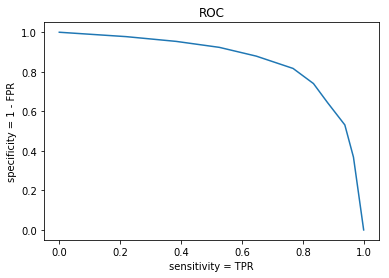

In [33]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
plt.plot(sensitivity, specificity)
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.title('ROC')
plt.savefig('logreg_baseline_ROC.png')

print('auc')
print(auc(sensitivity,specificity)) #auc takes in arguments (x,y)

# SVM Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, auc, roc_auc_score

gamma = np.logspace(-5,1,7)
accuracy = np.zeros(len(gamma))
sensitivity = np.zeros(len(gamma))
specificity = np.zeros(len(gamma))
precision = np.zeros(len(gamma))

for i in range(len(gamma)):
    
    SV_classifier = SVC(C = 0.1, gamma = gamma[i], kernel = 'rbf', random_state = 0)
    SV_classifier.fit(X_train,y_train)

    predict = SV_classifier.predict(X_val)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

In [ ]:
plt.plot(gamma,accuracy, label = 'accuracy')
plt.plot(gamma,sensitivity, label = 'sensitivity')
plt.plot(gamma,specificity, label = 'specificity')
plt.legend()
plt.xscale('log')
plt.xlabel('gamma')
plt.savefig('SVM_classifier_C01.png')

# Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegressionCV

alpha = np.logspace(-3,3,7)
C = 1/alpha
log_regressor_L2reg = LogisticRegressionCV(Cs = C, cv=10, random_state=0, penalty = 'l2').fit(X_trainval, y_trainval)

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

In [30]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score

threshold = np.arange(0,1.1,0.1)
accuracy_L2 = np.zeros(len(threshold))
sensitivity_L2 = np.zeros(len(threshold))
specificity_L2 = np.zeros(len(threshold))
precision_L2 = np.zeros(len(threshold))

for i in range(len(threshold)):

    predict = (log_regressor_L2reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy_L2[i] = np.mean(predict == y_val)
    sensitivity_L2[i] = TP / (TP + FN)
    specificity_L2[i] = TN / (TN + FP)
    precision_L2[i] = TP / (TP + FP)

recall_L2 = sensitivity_L2.copy()

print('accuracy values')
print(accuracy_L2)
print('sensitivity values')
print(sensitivity_L2)
print('specificity values')
print(specificity_L2)

accuracy values
[0.43841808 0.6180791  0.70169492 0.75367232 0.79322034 0.80451977
 0.77966102 0.75028249 0.70282486 0.62372881 0.56158192]
sensitivity values
[1.         0.97680412 0.95360825 0.90463918 0.85824742 0.78092784
 0.63659794 0.5128866  0.36082474 0.15979381 0.        ]
specificity values
[0.         0.33802817 0.50503018 0.63581489 0.74245473 0.82293763
 0.89134809 0.93561368 0.96981891 0.98591549 1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.8709602978696924


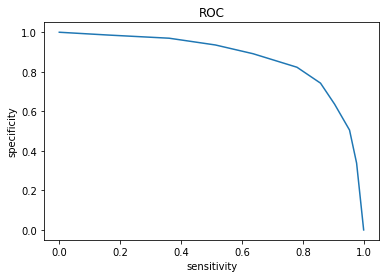

In [31]:
plt.plot(sensitivity_L2, specificity_L2)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.title('ROC')
plt.savefig('logreg_L2_ROC.png')

print('auc')
print(auc(sensitivity_L2,specificity_L2)) #auc takes in arguments (x,y)

In [25]:
from sklearn.linear_model import LogisticRegressionCV

alpha = np.logspace(-3,3,7)
C = 1/alpha
log_regressor_L1reg = LogisticRegressionCV(Cs = C, cv=10, random_state=0, penalty = 'l1', solver = 'liblinear').fit(X_trainval, y_trainval)

In [28]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score

threshold = np.arange(0,1.1,0.1)
accuracy_L1 = np.zeros(len(threshold))
sensitivity_L1 = np.zeros(len(threshold))
specificity_L1 = np.zeros(len(threshold))
precision_L1 = np.zeros(len(threshold))

for i in range(len(threshold)):

    predict = (log_regressor_L1reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy_L1[i] = np.mean(predict == y_val)
    sensitivity_L1[i] = TP / (TP + FN)
    specificity_L1[i] = TN / (TN + FP)
    precision_L1[i] = TP / (TP + FP)

recall_L1 = sensitivity_L1.copy()

print('accuracy values')
print(accuracy_L1)
print('sensitivity values')
print(sensitivity_L1)
print('specificity values')
print(specificity_L1)

accuracy values
[0.43841808 0.62824859 0.70734463 0.75819209 0.78983051 0.8079096
 0.79322034 0.75706215 0.71073446 0.63728814 0.56158192]
sensitivity values
[1.         0.97164948 0.95103093 0.89948454 0.85309278 0.78865979
 0.66237113 0.52835052 0.38917526 0.19329897 0.        ]
specificity values
[0.         0.36016097 0.51710262 0.64788732 0.74044266 0.82293763
 0.89537223 0.93561368 0.96177062 0.98390342 1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.8722748864319939


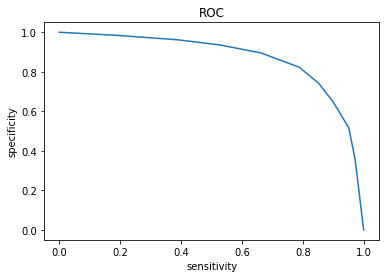

In [29]:
plt.plot(sensitivity_L1, specificity_L1)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.title('ROC')
plt.savefig('logreg_L1_ROC.png')

print('auc')
print(auc(sensitivity_L1,specificity_L1)) #auc takes in arguments (x,y)

auc
0.857451409487855
0.8722748864319939
0.8709602978696924


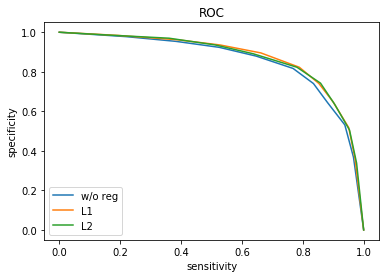

In [35]:
plt.plot(sensitivity, specificity, label = 'w/o reg')
plt.plot(sensitivity_L1, specificity_L1, label = 'L1')
plt.plot(sensitivity_L2, specificity_L2, label = 'L2')

plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.title('ROC')
plt.legend()
plt.savefig('logreg_comparison_ROC.png')

print('auc')
print(auc(sensitivity,specificity)) #auc takes in arguments (x,y)
print(auc(sensitivity_L1,specificity_L1)) #auc takes in arguments (x,y)
print(auc(sensitivity_L2,specificity_L2)) #auc takes in arguments (x,y)

## Prediction of Best Model on Test Set

In [36]:
# Best Model is Logistic Regression with L1 regularization

threshold = 0.5 
predict = (log_regressor_L1reg.predict_proba(X_test)[:,1] >= threshold).astype(int)

TN, FP, FN, TP = confusion_matrix(y_test,predict).ravel()

accuracy = np.mean(predict == y_test)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

accuracy values
0.7694394213381555
sensitivity values
0.7127882599580713
specificity values
0.8124006359300477
